In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import technical_analysis.backtest_kz as bt
from data_pipelines.data_manipulation import DataManipulation
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = 'ignore', category = pd.errors.PerformanceWarning)
%matplotlib inline

In [3]:
SYMBOL = 'BTC-USD'
scale = 1
range_list = [5, 10, 15, 20, 25, 30, 50, 99]
range_list = [i*scale for i in range_list]
period = 'max'
interval = '1d'
start_date = ''
end_data = ''
source = 'yahoo'

In [4]:
data = DataManipulation(SYMBOL, source, range_list, period=period, interval=interval, scale=scale, prefix_path='..')

In [5]:
features_labels = data.extract_features()

In [6]:
features_labels.shape

(2387, 115)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [9]:
X_train = features_labels[:'2021-06-01']
X_test = features_labels['2021-06-01':]

In [10]:
X_train.shape, X_test.shape

((1861, 115), (527, 115))

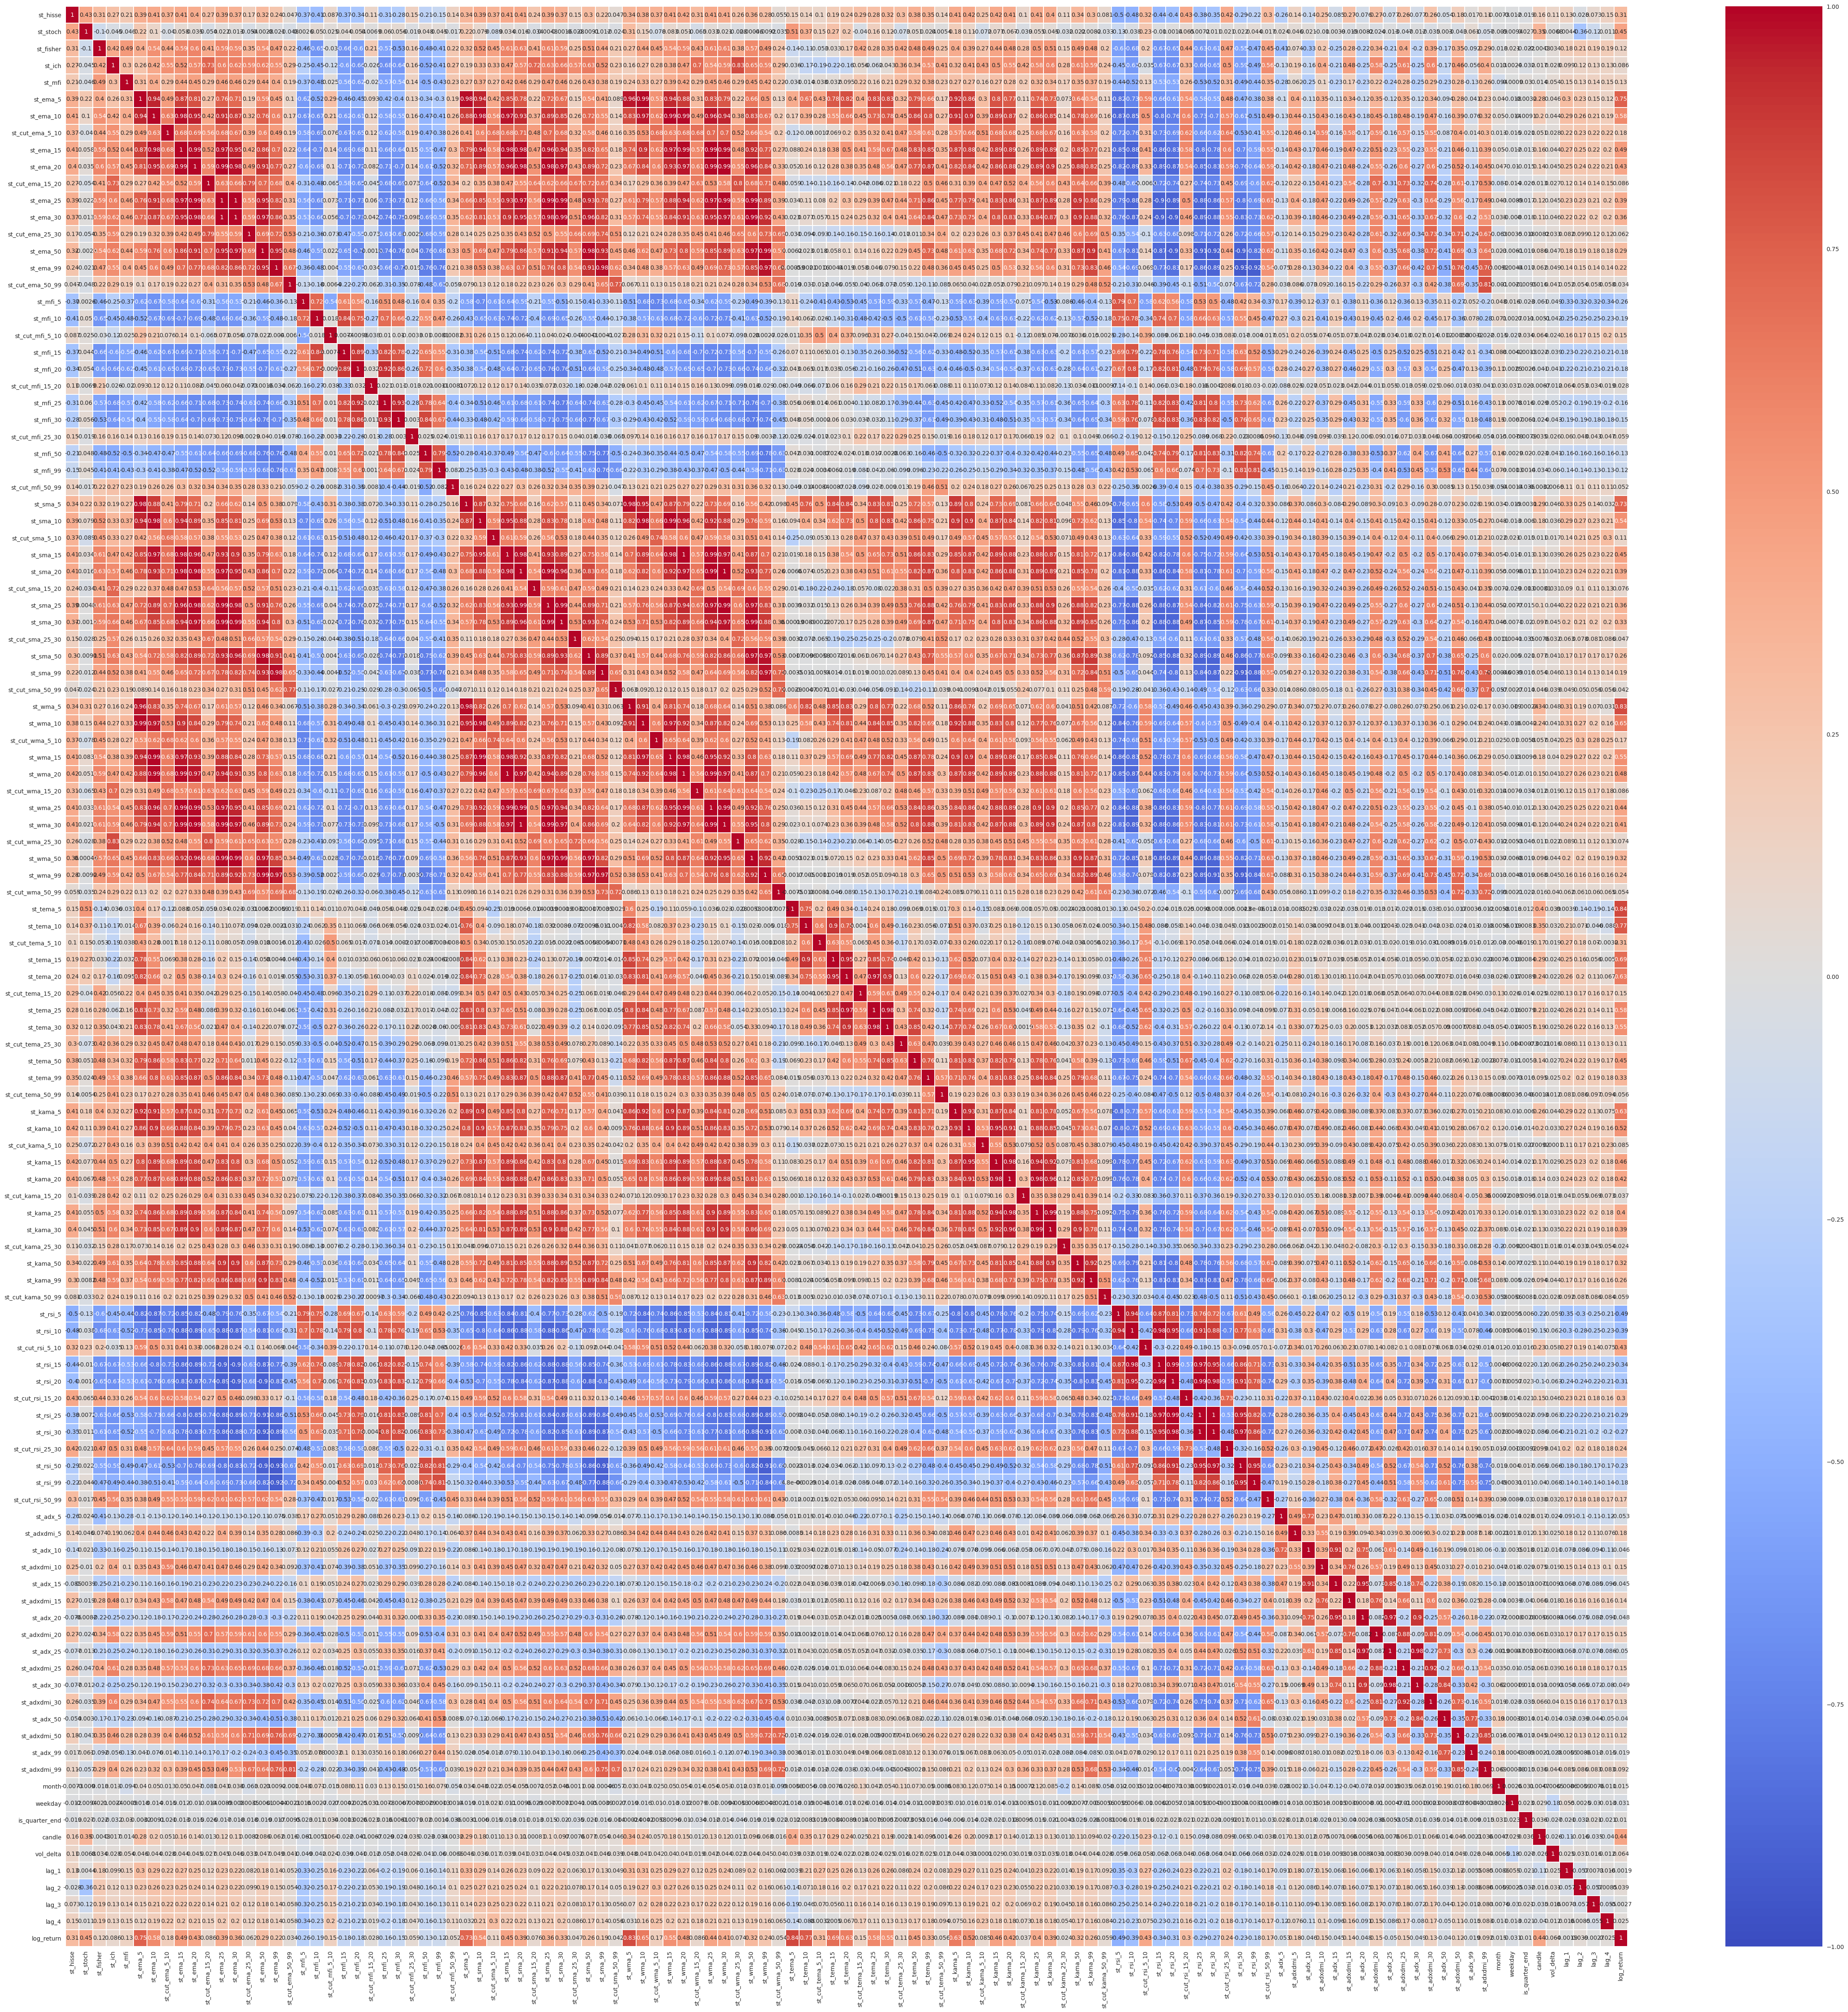

In [11]:
plt.figure(figsize=(60,60))
sns.heatmap(X_train.corr(), 
            vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.show()

In [12]:
correlation_matrix = X_train.corr()

In [13]:
correlation_matrix['log_return'].sort_values().tail(20)

st_sma_15    0.4482
st_kama_15   0.4565
st_wma_20    0.4831
st_ema_15    0.4891
st_kama_10   0.5207
st_sma_10    0.5412
st_tema_30   0.5452
st_wma_15    0.5465
st_ema_10    0.5779
st_tema_25   0.5824
st_tema_20   0.6301
st_kama_5    0.6339
st_wma_10    0.6464
st_tema_15   0.6920
st_sma_5     0.7332
st_ema_5     0.7454
st_tema_10   0.7710
st_wma_5     0.8276
st_tema_5    0.8407
log_return   1.0000
Name: log_return, dtype: float64

In [14]:
X_tr = X_train.drop("log_return", axis=1)
y_tr = X_train["log_return"]   

In [15]:
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [16]:
X_t = X_test.drop("log_return", axis=1)
y_t = X_test["log_return"]

In [17]:
# A parameter grid for XGBoost
params = {
    'min_child_weight': [4, 5],
    'gamma': [i / 10.0 for i in range(3, 6)],
    'subsample': [i / 10.0 for i in range(6, 11)],
    'colsample_bytree': [i / 10.0 for i in range(6, 11)],
    'max_depth': [2, 3, 4]
}
# Initialize XGB and GridSearch
xgb_reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror')
grid = GridSearchCV(xgb_reg, params)
grid.fit(X_tr, y_tr)
gridcv_xgb = grid.best_estimator_
print(r2_score(y_t, gridcv_xgb.predict(X_t)))

0.6862787888376214


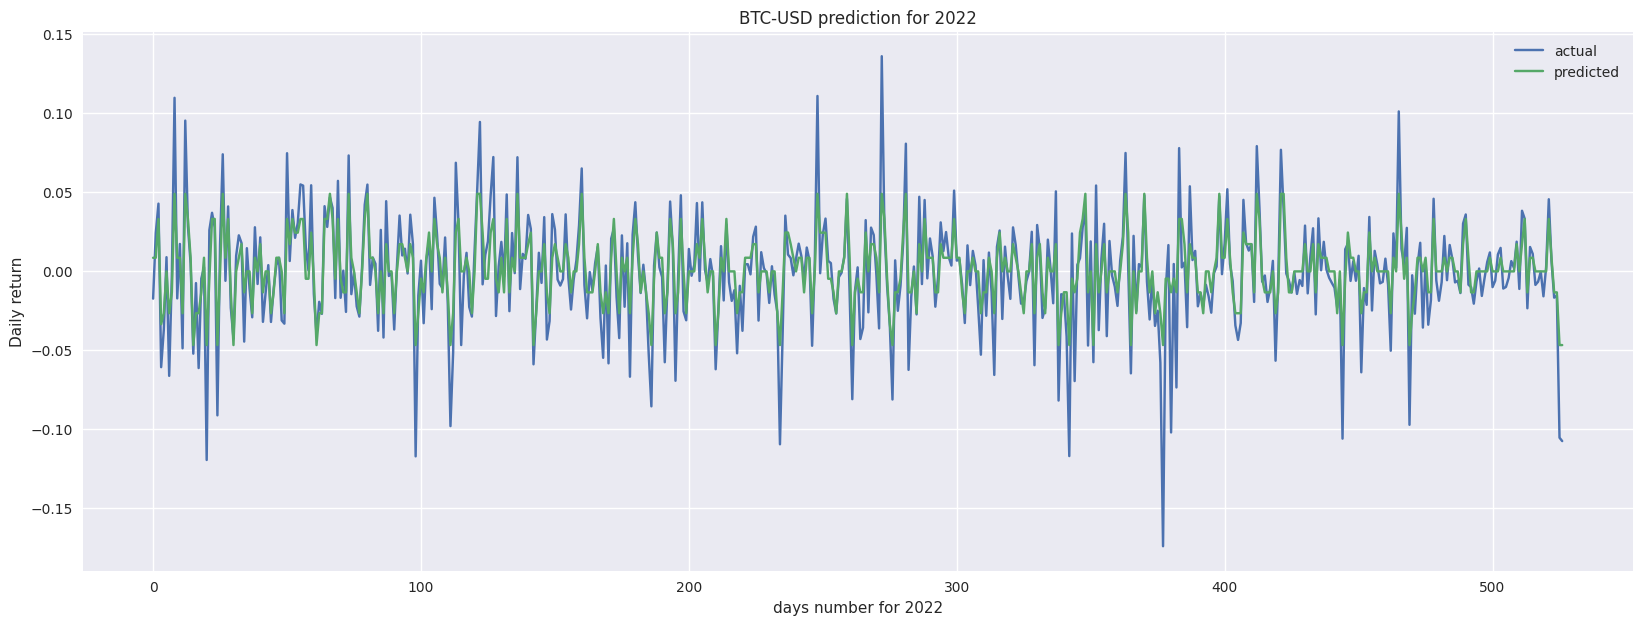

In [18]:
y_t = y_t.reset_index()
y_pred = gridcv_xgb.predict(X_t)
y_pred = pd.DataFrame(y_pred)
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(y_t.log_return, label='actual')
ax.plot(y_pred, label='predicted')
ax.set_ylabel('Daily return')
ax.set_xlabel('days number for 2022')
ax.set_title(f'{SYMBOL} prediction for 2022')
ax.legend()